# CatBoost tuning
Goal: tune a Catboost model.
<br>Learn more about the algorithm [here](https://catboost.ai/docs/).
***

## Table of Contents 

1. [Intuition Behind Tuning Approach](#1.-Intuition-Behind-Tuning-Approach)
2. [Intuition Behind Evaluation Metrics](#2.-Intuition-Behind-Evaluation-Metrics)
3. [Load Data](#3.-Load-Data)
4. [Define Functions](#4.-Define-Functions)
5. [Building a Baseline Model](#5.-Building-a-Baseline-Model)
6. [Equalize Class Imbalance](#6.-Equalize-Class-Imbalance)
7. [Control Overfitting](#7.-Control-Overfitting)
<br>7.1 [Parameters iterations, use_best_model, od_type, od_wait](#7.1-Parameters-iterations,-use_best_model,-od_type,-od_wait)
<br>7.2 [Paramter max_depth](#7.2-Parameter-max_depth)
8. [L2 Regularization](#8.-L2-Regularization)
<br>8.1 [Parameter reg_lambda](#8.1-Parameter-reg_lambda)
9. [Control Overfitting (continued)](#9.-Control-Overfitting-(continued))
<br>9.1 [Parameter random_strength](#9.1-Parameter-random_strength)
10. [Bagging](#10.-Bagging)
<br>10.1 [Parameter bagging_temperature](#10.1-Parameter-bagging_temperature)
11. [Iteration Comparisons](#11.-Iteration-Comparisons)
12. [Final Model](#12.-Final-Model)

## 1. Intuition Behind Tuning Approach
1. **Build a baseline model** to measure efficacy of parameter tuning for evaluation metric improvements.
2. **Equalize the class imbalance** to get a more reliable evaluation of model performance.
3. **Control overfitting** and tune parameters for the leaf-wise (best-first) tree.
4. **Regularize** predictions.
5. Further **control overfitting**.
6. Perform **bagging**.

I used the [parameter tuning](https://catboost.ai/docs/concepts/parameter-tuning.html) page on the CatBoost documentation as a guideline for tuning the hyperparameters in this notebook.

## 2. Intuition Behind Evaluation Metrics
We'll use the following metrics to evaluate our model's performance, given the imbalanced classes in the target variable:
1. AUC
2. AUCPR
3. Precision
4. Recall
5. F1-score
6. Logloss

Read more about the intuition behind choosing evaluation metrics [here](https://github.com/ayn28/churn-prediction-modeling/blob/master/model-tuning/XGBoost-tuning.ipynb).

## 3. Load Data

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Import cleaned datasets
df = pd.read_csv('data/cleaned_data/og_cleaned_samples.csv', index_col='customerID')
df_cat_encoded = pd.read_csv('data/cleaned_data/num_cleaned_samples.csv', index_col='customerID')

# Create features and target arrays
X = df_cat_encoded.drop(['Churn_Yes', 'gender_Male'], axis=1).values
y = df_cat_encoded.Churn_Yes.values

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

To create our features array, we drop the Churn feature since that is our target variable and we are trying to predict its labels. From our EDA, we determined that a customer's gender likely has no effect on their propensity to churn since it wasn't strongly correlated with other features and had no notable differences in churn rates between genders.

## 4. Define Functions

In [2]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Define function to calculate evaluation metrics.
def metrics(clf_name, ordered_dict):
    """Calculate and output evaluation metrics."""
    # Print best iteration round number
    best_iteration = clf_name.best_iteration_
    # Calculate AUCPR
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    auc_mtr = clf_name.best_score_['validation']['AUC']
    aucpr_mtr = average_precision_score(y_test, preds)
    logloss_mtr = clf_name.best_score_['validation']['Logloss']
    precision_mtr = clf_name.best_score_['validation']['Precision']
    recall_mtr = clf_name.best_score_['validation']['Recall']
    f1_mtr = clf_name.best_score_['validation']['F1']
    # Print metrics
    print('Best iteration: {} rounds.'.format(best_iteration))
    print('AUC:       {0:.3f}'.format(auc_mtr))
    print('AUCPR:     {0:.3f}'.format(aucpr_mtr))
    print('Logloss:   {0:.3f}'.format(logloss_mtr))
    print('Precision: {0:.3f}'.format(precision_mtr))
    print('Recall:    {0:.3f}'.format(recall_mtr))
    print('F1-score:  {0:.3f}'.format(f1_mtr))
    # Append metrics to an ordered dictionary (for plotting)
    ordered_dict['Best_iteration'] = best_iteration
    ordered_dict['AUC'] = round(auc_mtr, 3)
    ordered_dict['AUCPR'] = round(aucpr_mtr, 3)
    ordered_dict['Logloss'] = round(logloss_mtr, 3)
    ordered_dict['Precision'] = round(precision_mtr, 3)
    ordered_dict['Recall'] = round(recall_mtr, 3)
    ordered_dict['F1_score'] = round(f1_mtr, 3)

# Define function to plot ROC and PR curve.
def plot_roc_pr(clf_name):
    """Plot the ROC and PR-curve for a given classifier."""
    plt.figure(figsize=(14, 7))
    # Plot ROC
    plt.subplot(121)
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # Plot PR curve
    plt.subplot(122)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    average_precision = average_precision_score(y_test, preds)
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    
# Define function to plot metric changes between consecutive iterations.
def plot_consec_metric_delta(label1, dict1, label2, dict2):
    """Plot the metric changes between consecutive iterations."""
    df = pd.DataFrame(
        data=[[val for (metric, val) in dict1.items()],
              [val for (metric, val) in dict2.items()]],
        columns=[metric for (metric, val) in dict1.items()]
    )
    # Store best iterations
    bst_iters = list(df['Best_iteration'])
    # Drop the 'Best_iteration' column inplace
    df.drop(['Best_iteration'], axis=1, inplace=True)
    # Define # of iterations you want to plot
    N = 2
    ind = np.arange(N)    
    # Plot metrics
    plt.figure(figsize=(6, 6))
    for metric in list(df.columns):
        plt.plot(ind, df[metric].values, linewidth=1.5, marker='o', label=metric);
    plt.xticks(
        ticks=np.arange(N),
        labels=[
            '{}\n{} rounds'.format(label1, bst_iters[0]),
            '{}\n{} rounds'.format(label2, bst_iters[1])])
    # Fixed
    plt.title('Evaluation Metrics Over Consecutive Iterations', fontsize=13)
    plt.ylabel('Value', fontsize=12)
    plt.xlabel('Iteration', fontsize=12)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show()

## 5. Building a Baseline Model
In order to get an idea of the range of precision and recall we would like our model to surpass, we are going to build a baseline model and save its score for later. This score is what we can achieve with no tuning. 

In [3]:
from catboost import CatBoostClassifier

# Define baseline parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     # metric used in training; objective function
    'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'],   # metric vals output during training; not optimized; displayed for informational purposes only
    'eval_metric': 'AUC' # metric used for overfitting detection and best model selection
}

# Instantiate a classifier using all default params (except seed)
clf_baseline = CatBoostClassifier(**params)

# Fit classifier
clf_baseline.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics
clf_baseline_dict = OrderedDict()
metrics(clf_baseline, clf_baseline_dict)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 55 rounds.
AUC:       0.842
AUCPR:     0.648
Logloss:   0.420
Precision: 0.684
Recall:    0.624
F1-score:  0.598


With the model's parameters set to their default values and no tuning, we get the baseline metric scores listed above. Let's tweak a few parameters and potentially increase our baseline scores.


## 6. Equalize Class Imbalance
Setting the scale_pos_weight parameter to the ratio of negative-to-positive classes will help equalize the class imbalance. It's acceptable to now use AUC for model evaluation since the ROC curve is less weighted towards the true negatives thereby providing a less biased representation of the model's performance.

In [4]:
from catboost import Pool

# Load data into Pool objects (optimized for CatBoost)
ptrain = Pool(X_train, label=y_train)
ptest = Pool(X_test, label=y_test)

# Balance the positive and negative weights and assign it to the scale_pos_weight parameter
train_labels = ptrain.get_label()
pos_class = sum(i for i in train_labels)
neg_class = len(train_labels) - pos_class
ratio = neg_class / pos_class   # sum_negative / sum_positive
print('Value for scale_pos_weight: {:.2f}'.format(ratio))

Value for scale_pos_weight: 2.76


In [5]:
# Set hyperparameters
# (added the scale_pos_weight parameter)
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'], 
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76
}

# Instantiate classifier
clf_equalize = CatBoostClassifier(**params)

# Fit classifier
clf_equalize.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_equalize_dict = OrderedDict()
metrics(clf_equalize, clf_equalize_dict)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 128 rounds.
AUC:       0.841
AUCPR:     0.652
Logloss:   0.491
Precision: 0.750
Recall:    0.816
F1-score:  0.779


Rebalancing the class weights effected our model's evaluation metrics, especially its recall value. Let's compare the baseline model to the equalized model and further analyze the changes.

Baseline model:
Best iteration: 55 rounds.
AUC:       0.842
AUCPR:     0.648
Logloss:   0.420
Precision: 0.684
Recall:    0.624
F1-score:  0.598

Equalized model:
Best iteration: 128 rounds.
AUC:       0.841
AUCPR:     0.652
Logloss:   0.491
Precision: 0.750
Recall:    0.816
F1-score:  0.779


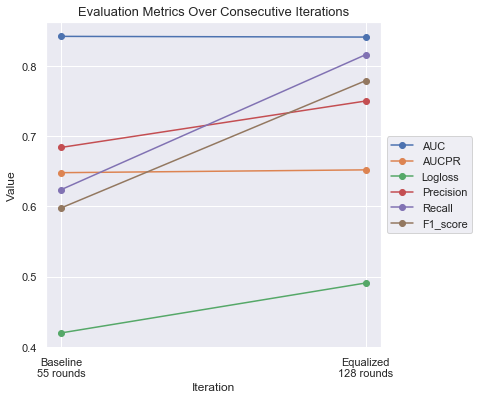

In [6]:
# Print evaluation metrics for baseline model
print('Baseline model:')
metrics(clf_baseline, clf_baseline_dict)

# Print evaluation metrics for equalized model
print('\nEqualized model:')
metrics(clf_equalize, clf_equalize_dict)

# Plot the changes between both iterations
plot_consec_metric_delta('Baseline', clf_baseline_dict, 'Equalized', clf_equalize_dict)

* Every evaluation metric value increased after balancing the classes.
* Given each positive "churn" class is weighted about 3 times more than the negative, the model's ability to classify "churn" samples significantly increased - shown by the increased recall. 
* The model's precision score has surprisingly increased, given it was decreasing at this iteration for the XGBoost and LightGBM models.
***

## 7. Control Overfitting
According to the CatBoost documentation:
<br><br>"It is recommended to check that there is no obvious underfitting or overfitting before tuning any other parameters. In order to do this it is necessary to analyze the metric value on the validation dataset and select the appropriate number of iterations.""

### 7.1 Parameters iterations, use_best_model, od_type, od_wait
##### Tuning for number of trees and learning rate.

"This can be done by setting the number of **iterations** to a large value, using the **overfitting detector** parameters and turning the **use best model** options on. In this case the resulting model contains only the first k best iterations, where k is the iteration with the best loss value on the validation dataset.

Also, the metric for choosing the best model may differ from the one used for optimizing the objective value. For example, it is possible to set the optimized function to Logloss and use the AUC function for the overfitting detector. To do so, use the **evaluation metric** parameter."

* **iterations**: The maximum number of trees that can be built when solving machine learning problems (aliases: num_boost_round, n_estimators, and num_trees).
* **use_best_model**: Use the validation dataset to identify the iteration with the optimal value of the evaluation metric.
* **od_type**: The type of the overfitting detector to use.
* **od_wait**: The number of iterations to continue the training after the iteration with the optimal metric value.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 65 rounds.
AUC:       0.842
AUCPR:     0.653
Logloss:   0.488
Precision: 0.750
Recall:    0.824
F1-score:  0.779


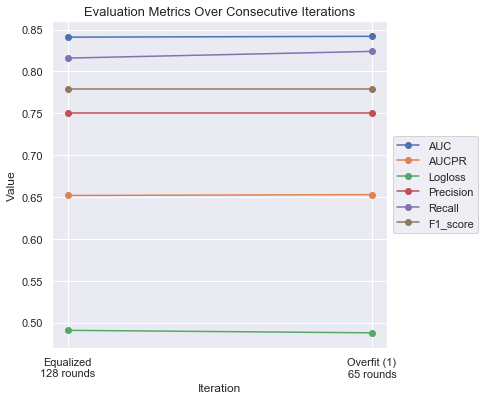

In [7]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'], 
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76,
    'iterations': 3000,        # finding best iteration
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 20
}

# Instantiate classifier
clf_of1 = CatBoostClassifier(**params)

# Fit classifier
clf_of1.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,   
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_of1_dict = OrderedDict()
metrics(clf_of1, clf_of1_dict)
plot_consec_metric_delta('Equalized', clf_equalize_dict, 'Overfit (1)', clf_of1_dict)

The best number of trees, or iterations, to use that optimize the AUC score is at **65 trees**. We'll set our **iterations** parameter to 65. 

According to the CatBoost documentation on tuning the [learning rate](https://catboost.ai/docs/concepts/parameter-tuning.html#learning-rate), by default, the learning rate is defined automatically based on the dataset properties and the number of iterations and the automatically defined value should be close to the optimal one.

To better understand how the learning rate automatically changes with each iteration, the learning rate for our baseline model is **0.09** (see subsequent kernel below) at 55 iterations.

In [8]:
# Output learning rate for baseline model
clf_baseline.learning_rate_

0.09224099666

And the learning rate for the first iteration of overfitting tuning is **0.06** (see subsequent kernel below) at 65 iterations.

In [9]:
# Output learning rate for first iteration of overfitting tuning
clf_of1.learning_rate_

0.05763899907

* We can see as the number of iterations increased, the value for the learning rate automatically decreased - the smaller the learning rate, the more iterations are required for training.
* The learning_rate parameter automatically changes based on the hyperparameters at each iteration.
* We won't define a learning rate just yet, rather we'll use the learning rate at the best iteration. 

### 7.2 Parameter max_depth
##### Tuning for tree depth.
In most cases, the optimal depth ranges from 4 to 10. Values in the range from 6 to 10 are recommended.
* **max_depth**: Depth of the tree. (default: 6)

In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time 

# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
#     'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'],   # N/A to gridsearch
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76,
    'iterations': 65,        
#     'use_best_model': True,  # N/A to gridsearch
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0
}

# Parameters to tune
param_grid = {
    'max_depth': np.arange(3, 11, 1)
}

clf_of2_grid = GridSearchCV(
    estimator=CatBoostClassifier(**params),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=0
)

# Fit the grid search object
%time clf_of2_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_of2_grid.best_score_))
print('Best params:')
for key, val in clf_of2_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

CPU times: user 3min 3s, sys: 17 s, total: 3min 20s
Wall time: 38.2 s
Best AUC score: 0.849
Best params:
	max_depth: 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 305 rounds.
AUC:       0.841
AUCPR:     0.651
Logloss:   0.489
Precision: 0.741
Recall:    0.877
F1-score:  0.779


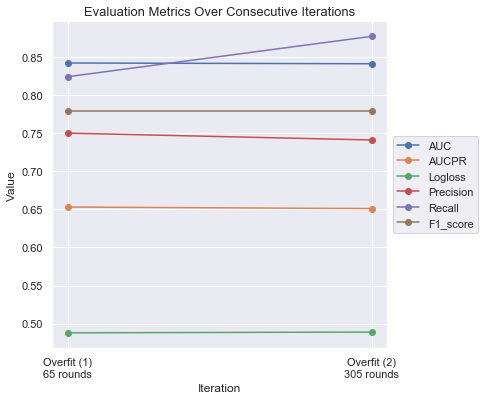

In [11]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'], 
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76,
    'iterations': 3000,        # finding best iteration
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0,
    'max_depth': 3
}

# Instantiate classifier
clf_of2 = CatBoostClassifier(**params)

# Fit classifier
clf_of2.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,   
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_of2_dict = OrderedDict()
metrics(clf_of2, clf_of2_dict)
plot_consec_metric_delta('Overfit (1)', clf_of1_dict, 'Overfit (2)', clf_of2_dict)

* The recall value substantially increased by limiting the depth of our tree and the model's complexity.
* By examining training and testing recall curves, we can see that the max recall value is at a high training and testing value - which is indicative of an overfit recall value.
* Let's regularize the classifications to control the model from overfitting and produce a more reliable recall value. 

## 8. L2 Regularization
### 8.1 Parameter reg_lambda
Try different values for the regularizer to find the best possible.
* **reg_lambda**: Coefficient at the L2 regularization term of the cost function. (default: 3.0)

In [12]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
#     'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'],   # N/A to gridsearch
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76,
    'iterations': 65,        
#     'use_best_model': True,  # N/A to gridsearch
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0,
    'max_depth': 3
}

# Parameters to tune
param_grid = {
    'reg_lambda': np.arange(1, 40, 1)
}

clf_reg_grid = GridSearchCV(
    estimator=CatBoostClassifier(**params),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=0
)

# Fit the grid search object
%time clf_reg_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_reg_grid.best_score_))
print('Best params:')
for key, val in clf_reg_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

CPU times: user 10min 6s, sys: 30 s, total: 10min 36s
Wall time: 1min 39s
Best AUC score: 0.846
Best params:
	reg_lambda: 6


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 263 rounds.
AUC:       0.840
AUCPR:     0.650
Logloss:   0.490
Precision: 0.734
Recall:    0.845
F1-score:  0.773


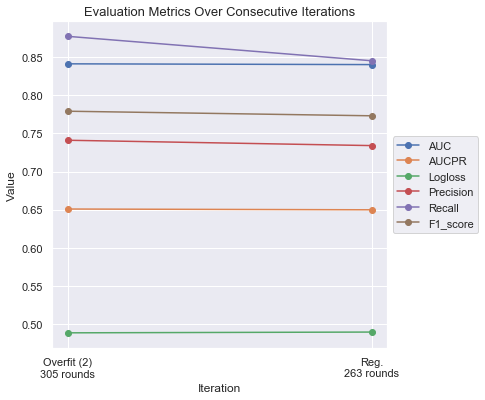

In [14]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'], 
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76,
    'iterations': 3000,        # finding best iteration
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0,
    'max_depth': 3,
    'reg_lambda': 6
}

# Instantiate classifier
clf_reg = CatBoostClassifier(**params)

# Fit classifier
clf_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,   
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_reg_dict = OrderedDict()
metrics(clf_reg, clf_reg_dict)
plot_consec_metric_delta('Overfit (2)', clf_of2_dict, 'Reg.', clf_reg_dict)

* The recall value dropped and is no longer overfit, given the testing value is less than the training value. 

In [27]:
clf_reg.learning_rate_

0.02999999933

The learning rate for this iteration's classifier is **0.03**. 

## 9. Control Overfitting (continued)
### 9.1 Parameter random_strength
The value of this parameter is used when selecting splits. On every iteration each possible split gets a score (for example, the score indicates how much adding this split will improve the loss function for the training dataset). The split with the highest score is selected.
* **random_strength**: The amount of randomness to use for scoring splits when the tree structure is selected. Use this parameter to avoid overfitting the model. (default: 1)

In [19]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
#     'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'],   # N/A to gridsearch
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76,
    'iterations': 65,        
#     'use_best_model': True,  # N/A to gridsearch
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0,
    'max_depth': 3,
    'reg_lambda': 6
}

# Parameters to tune
param_grid = {
    'random_strength': np.arange(1, 53, 2),
}

clf_of4_grid = GridSearchCV(
    estimator=CatBoostClassifier(**params),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=0
)

# Fit the grid search object
%time clf_of4_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_of4_grid.best_score_))
print('Best params:')
for key, val in clf_of4_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

CPU times: user 7min 18s, sys: 46.7 s, total: 8min 5s
Wall time: 1min 34s
Best AUC score: 0.846
Best params:
	random_strength: 1


* The optimal **random_strength** parameter of 1 is the same as the default value. 
* We'll define it in our paramaters dictionary, although not necessary, to keep the dictionary consistent with our tuning process.
* Let's test another parameter. 

## 10. Bagging
### 10.1 Parameter bagging_temperature
This parameter can be used if the selected bootstrap type is Bayesian.
* **bagging_temperature**: Defines the settings of the Bayesian bootstrap. It is used by default in classification and regression modes. Use the Bayesian bootstrap to assign random weights to objects. The weights are sampled from exponential distribution if the value of this parameter is set to “1”. All weights are equal to 1 if the value of this parameter is set to “0”. The higher the value the more aggressive the bagging is.

In [20]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
#     'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'],   # N/A to gridsearch
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76,
    'iterations': 65,        
#     'use_best_model': True,  # N/A to gridsearch
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0,
    'max_depth': 3,
    'reg_lambda': 6,
    'random_strength': 1
}

# Parameters to tune
param_grid = {
    'bagging_temperature': np.arange(1, 51, 1),
}

clf_bag_grid = GridSearchCV(
    estimator=CatBoostClassifier(**params),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=0
)

# Fit the grid search object
%time clf_bag_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_bag_grid.best_score_))
print('Best params:')
for key, val in clf_bag_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

CPU times: user 11min 31s, sys: 1min 6s, total: 12min 37s
Wall time: 2min 25s
Best AUC score: 0.847
Best params:
	bagging_temperature: 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best iteration: 218 rounds.
AUC:       0.842
AUCPR:     0.651
Logloss:   0.489
Precision: 0.738
Recall:    0.840
F1-score:  0.773


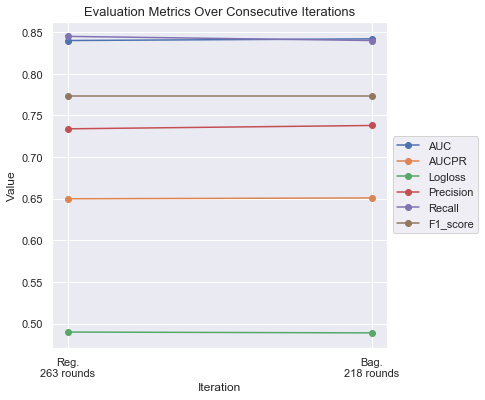

In [22]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'], 
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76,
    'iterations': 3000,        # finding best iteration
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0,
    'max_depth': 3,
    'reg_lambda': 6,
    'random_strength': 1,
    'bagging_temperature': 3
}

# Instantiate classifier
clf_bag = CatBoostClassifier(**params)

# Fit classifier
clf_bag.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,   
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_bag_dict = OrderedDict()
metrics(clf_bag, clf_bag_dict)
plot_consec_metric_delta('Reg.', clf_reg_dict, 'Bag.', clf_bag_dict)

* The evaluation metrics did not change much. 
* The number of trees, however, did decrease.
* Let's compare the changes across all iterations in the next section.

## 11. Iteration Comparisons

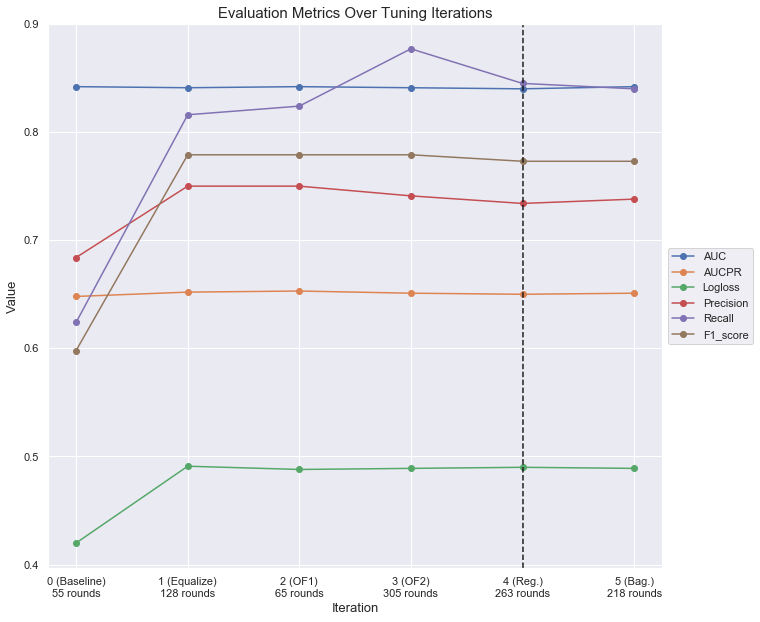

In [26]:
df_final = pd.DataFrame(
    data=[[val for (metric, val) in clf_baseline_dict.items()],
          [val for (metric, val) in clf_equalize_dict.items()],
          [val for (metric, val) in clf_of1_dict.items()],
          [val for (metric, val) in clf_of2_dict.items()],
          [val for (metric, val) in clf_reg_dict.items()],
          [val for (metric, val) in clf_bag_dict.items()]
         ],
    columns=[metric for (metric, val) in clf_baseline_dict.items()]
    )

# Store best iterations
bst_iters_final = list(df_final['Best_iteration'])

# Drop the 'Best_iteration' column inplace
df_final.drop(['Best_iteration'], axis=1, inplace=True)

# Define # of iterations you want to plot
N = len(df_final.columns)
ind = np.arange(N)    

# Plot metrics
plt.figure(figsize=(11, 10))
for metric in list(df_final.columns):
    plt.plot(ind, df_final[metric].values, linewidth=1.5, marker='o', label=metric);

plt.axvline(x=4, color='k', linestyle='--')

plt.xticks(
    ticks=np.arange(N),
    labels=[
        '0 (Baseline)\n{} rounds'.format(bst_iters_final[0]),
        '1 (Equalize)\n{} rounds'.format(bst_iters_final[1]),
        '2 (OF1)\n{} rounds'.format(bst_iters_final[2]),
        '3 (OF2)\n{} rounds'.format(bst_iters_final[3]),
        '4 (Reg.)\n{} rounds'.format(bst_iters_final[4]),
        '5 (Bag.)\n{} rounds'.format(bst_iters_final[5]),
    ])

# Fixed
plt.title('Evaluation Metrics Over Tuning Iterations', fontsize=15)
plt.ylabel('Value', fontsize=13)
plt.xlabel('Iteration', fontsize=13)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

**The CatBoost model performs best at the fourth iteration.**
* The high recall value at the 3rd iteration is misleading as it is likely overfit given its high training and testing value at that value; therefore, we shouldn't choose that iteration for its high recall.
* The following (fourth) iteration controls the overfit recall value from the prior iteration and has the next highest recall value.
* All the other evaluation metrics are relatively high and comparable to the latter iteration. 

## 12. Final Model

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

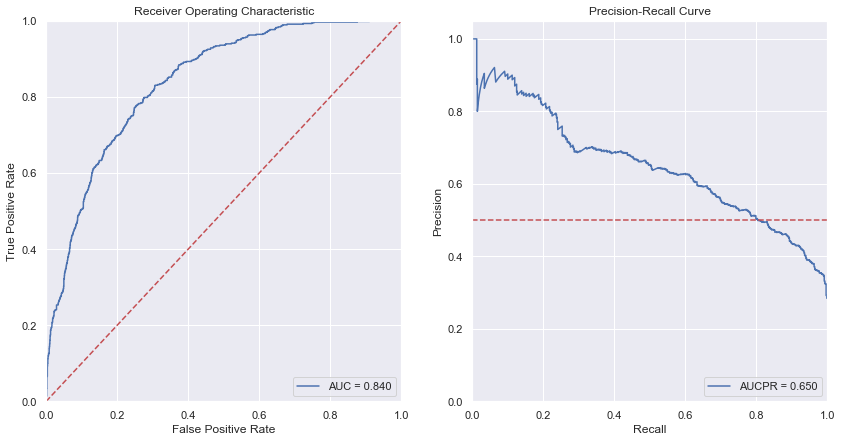

Best iteration: 263 rounds.
AUC:       0.840
AUCPR:     0.650
Logloss:   0.490
Precision: 0.734
Recall:    0.845
F1-score:  0.773


In [33]:
# Set parameters
params = {
    'random_state': 42,
    'loss_function': 'Logloss',     
    'custom_metric': ['Precision', 'Recall', 'F1', 'AUC'], 
    'eval_metric': 'AUC',
    'scale_pos_weight': 2.76,
    'iterations': 3000,        
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 0,
    'max_depth': 3,
    'reg_lambda': 6,
    'learning_rate': 0.03
}

# Instantiate classifier
clf_reg = CatBoostClassifier(**params)

# Fit classifier
clf_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,   
    use_best_model=True,
    verbose=0,
    plot=True
);

# Output evaluation metrics 
clf_reg_dict = OrderedDict()
plot_roc_pr(clf_reg)
metrics(clf_reg, clf_reg_dict)